In [20]:
from typing import List, Dict
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib
from pathlib import Path
import matplotlib.pyplot as plt
import load_workload_data as ld
import load_benchmark_data as bn


sns.set(rc={'figure.figsize':(7.5,10)})

In [21]:
benchmark = "tpch"
single_threaded_folder = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded")
multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_multithreaded/")
sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded/")
high_level_mult: DataFrame = bn.get_high_level(multi_threaded_folder, sizes_folder)
low_level_mult: DataFrame = bn.get_low_level(multi_threaded_folder)
high_level_single: DataFrame = bn.get_high_level(single_threaded_folder, sizes_folder)
low_level_single: DataFrame = bn.get_low_level(single_threaded_folder)
high_level_mult

,benchmark_run_name,Total Runtime (in seconds),avg_throughput,Compression Scheme,with_lto,Clients,multithreaded,float,int,string,Compression Scheme_baseline,Total Runtime (in seconds)_baseline,int_baseline,Runtime Library / Runtime Baseline,size_to_baseline
0,./tpch_CompactVector_28_sf10_shuffled.json,60.205721,0.460573,CompactVector,False,28,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,60.205721,1.372782e+09,1.000000,1.000000
1,./tpch_Dictionary_28_sf10_shuffled.json,60.205721,0.460573,Dictionary,False,28,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,60.205721,1.372782e+09,1.000000,1.000000
2,./tpch_FrameOfReference_28_sf10_shuffled.json,55.875643,0.490804,FrameOfReference,False,28,True,676386560.0,9.912806e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.928079,0.722096
3,./tpch_SIMDCAI_28_sf10_shuffled.json,58.858771,0.465884,SIMDCAI,False,28,True,676386560.0,6.464946e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.977628,0.470938
4,./tpch_TurboPFOR_28_sf10_shuffled.json,60.672550,0.452128,TurboPFOR,False,28,True,676386560.0,6.514422e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,1.007754,0.474542
5,./tpch_TurboPFOR_bitpacking_28_sf10_shuffled.json,56.325642,0.486986,TurboPFOR_bitpacking,False,28,True,676386560.0,6.557167e+08,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.935553,0.477655
6,./tpch_Unencoded_28_sf10_shuffled.json,54.443293,0.503728,Unencoded,False,28,True,676386560.0,1.266756e+09,7.950671e+09,Dictionary,60.205721,1.372782e+09,0.904288,0.922766
7,./tpch_Dictionary_14_sf10_shuffled.json,41.228798,0.336834,Dictionary,False,14,True,676386560.0,1.372782e+09,7.950671e+09,Dictionary,41.228798,1.372782e+09,1.000000,1.000000
8,./tpch_FrameOfReference_14_sf10_shuffled.json,38.446318,0.356780,FrameOfReference,False,14,True,676386560.0,9.912806e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.932511,0.722096
9,./tpch_SIMDCAI_14_sf10_shuffled.json,39.593418,0.346463,SIMDCAI,False,14,True,676386560.0,6.464946e+08,7.950671e+09,Dictionary,41.228798,1.372782e+09,0.960334,0.470938


## Runtime

In [22]:
only_28_clients: DataFrame = low_level_mult[low_level_mult[bn.CLIENTS] == 28]
single_with_unencoded_baseline: DataFrame = bn.get_relative_to_baseline_low_level(low_level_single, baseline="Unencoded")
multi_with_unencoded_baseline: DataFrame = bn.get_relative_to_baseline_low_level(only_28_clients, baseline="Unencoded")
sns.catplot(data=only_28_clients, kind="bar", x=bn.QUERY_NAME, y=bn.AVG_DURATION, hue=bn.LIBRARY_NAME, height=90, aspect=2)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'SIMDCAI'),
  Text(1, 0, 'Dictionary'),
  Text(2, 0, 'TurboPFOR'),
  Text(3, 0, 'Unencoded'),
  Text(4, 0, 'TurboPFOR_bitpacking'),
  Text(5, 0, 'FrameOfReference')])

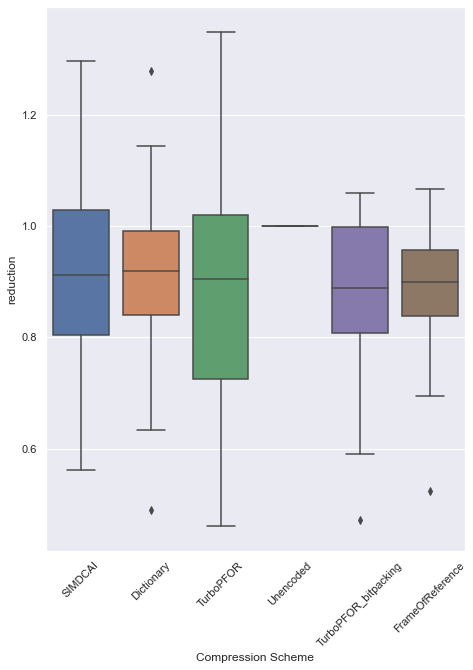

In [23]:
columns_to_merge: List[str] = [bn.QUERY_NAME, bn.LIBRARY_NAME, bn.RUNTIME_TO_BASELINE]
combined: DataFrame = single_with_unencoded_baseline.merge(multi_with_unencoded_baseline[columns_to_merge], on=[bn.LIBRARY_NAME, bn.QUERY_NAME])
combined[bn.REDUCTION] = [multi / single for single, multi
                         in zip(combined[f"{bn.RUNTIME_TO_BASELINE}_x"],
                                combined[f"{bn.RUNTIME_TO_BASELINE}_y"])]
sns.boxplot(data=combined, x=bn.LIBRARY_NAME, y=bn.REDUCTION)
plt.xticks(rotation=45)

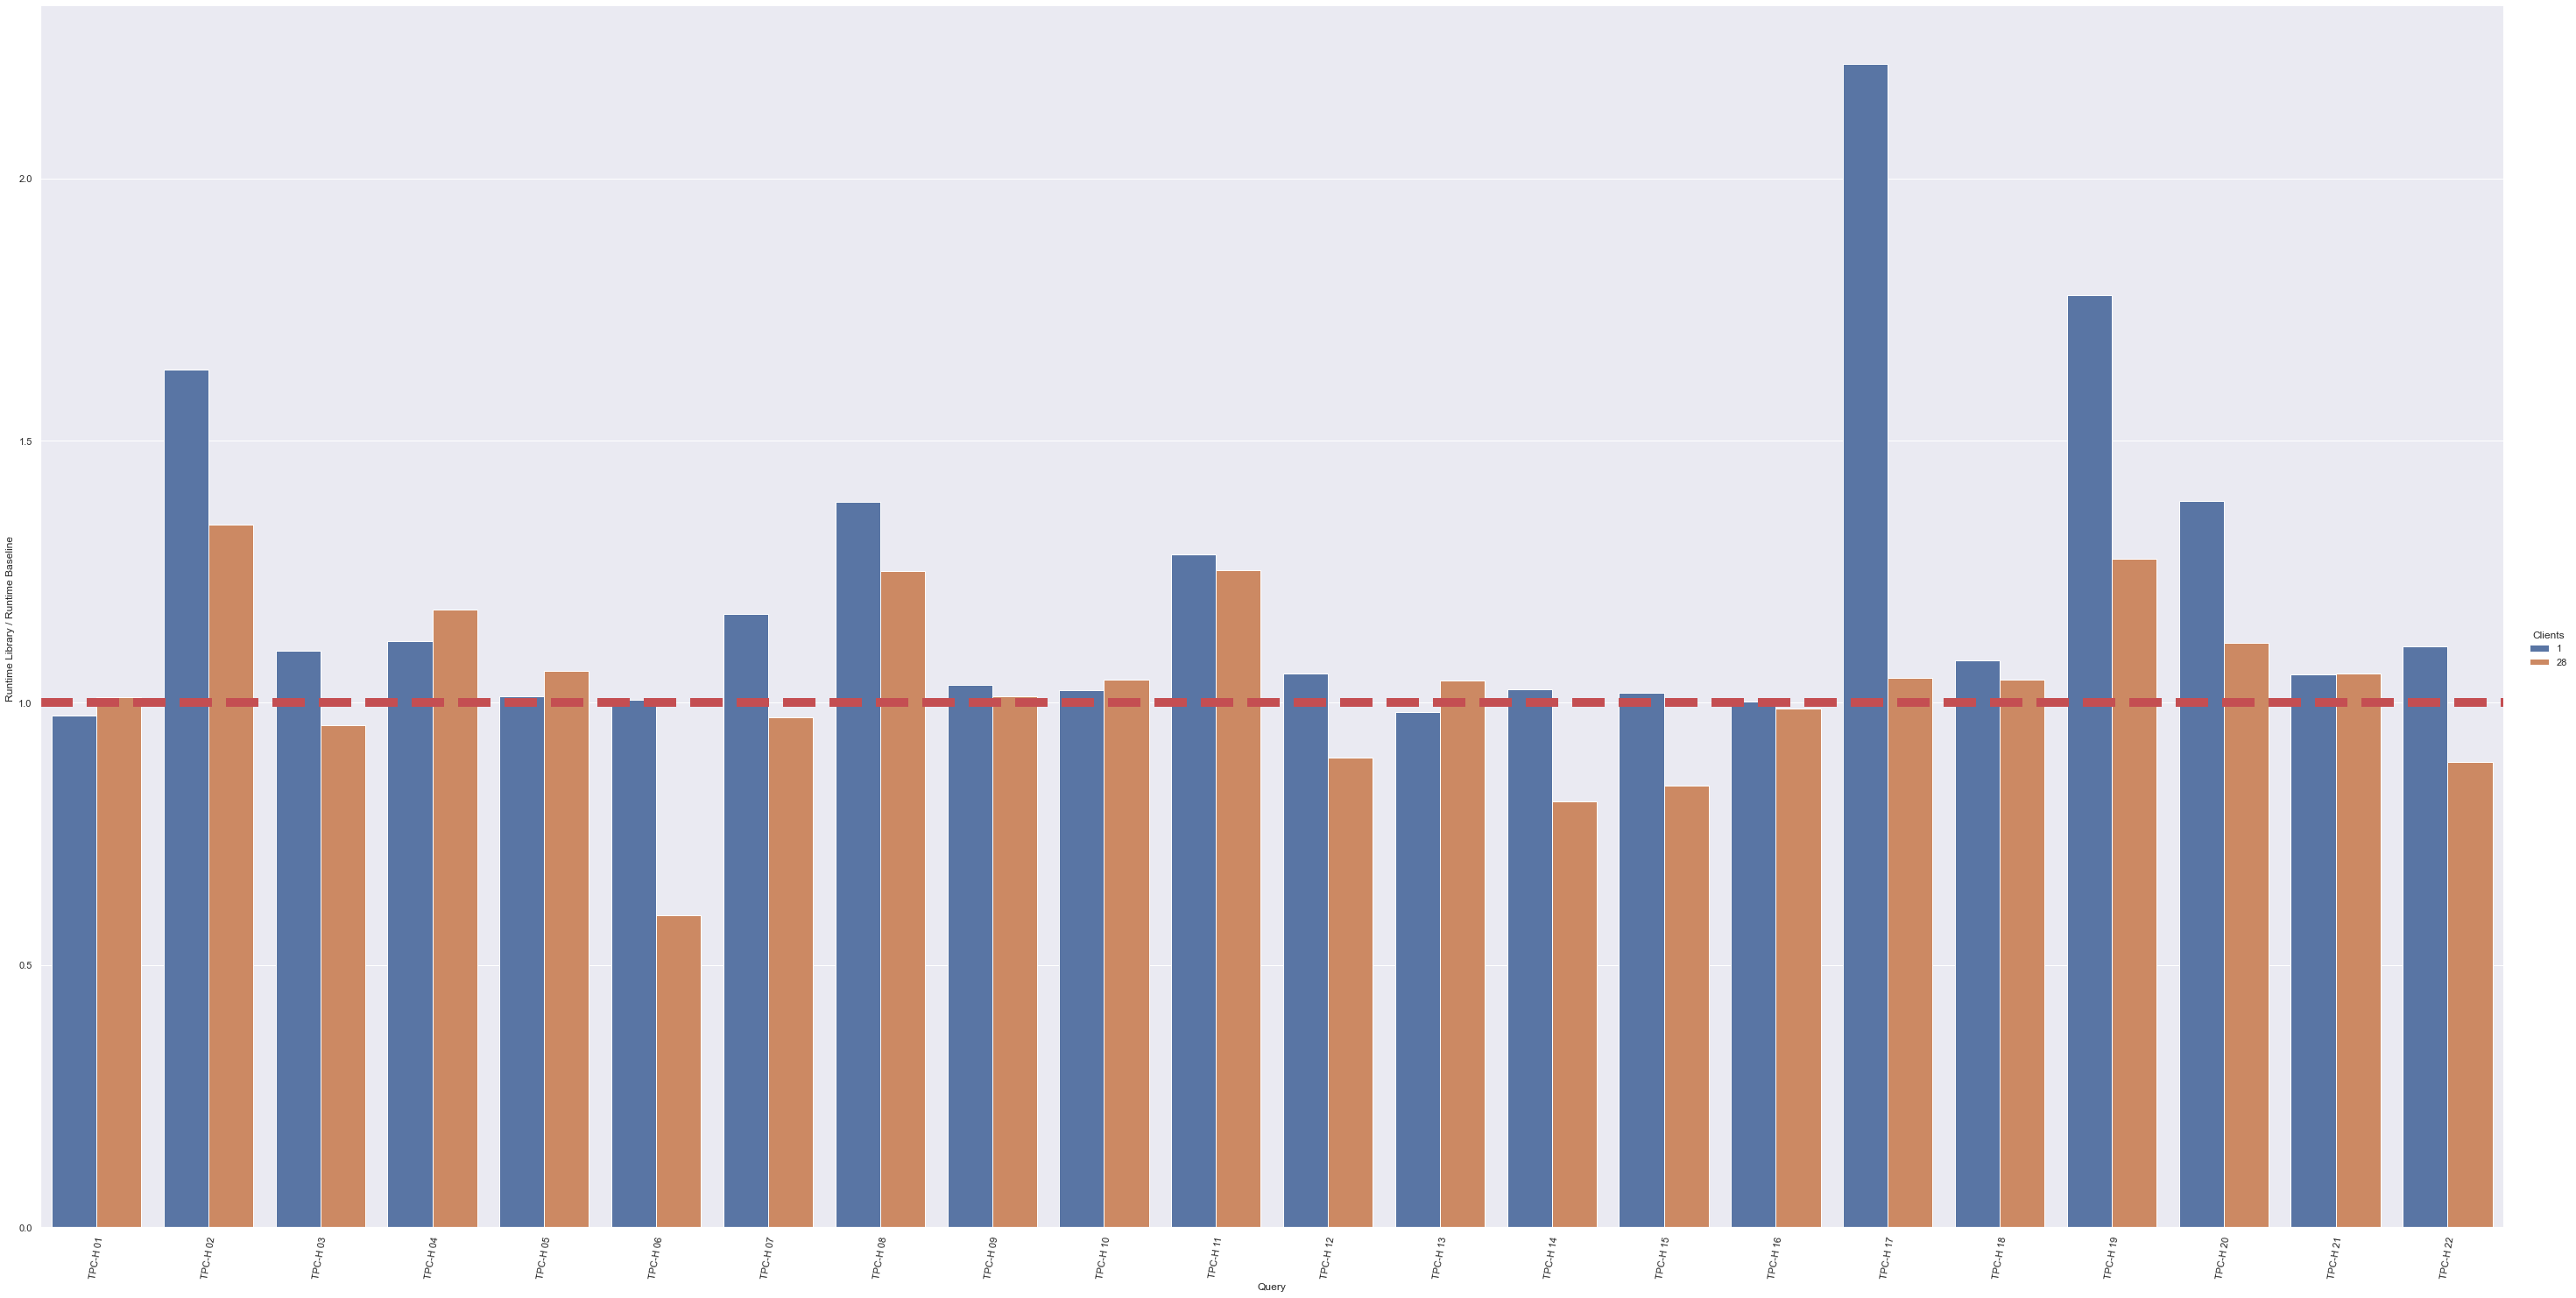

In [24]:
# Single vs. Multithreaded
appended: DataFrame = single_with_unencoded_baseline.append(multi_with_unencoded_baseline)
only_bitpacking: DataFrame = appended[appended[bn.LIBRARY_NAME] == "TurboPFOR_bitpacking"]
sns.catplot(data=only_bitpacking, x=bn.QUERY_NAME, y=bn.RUNTIME_TO_BASELINE, hue=bn.CLIENTS, kind="bar", height=20, aspect=2)
plt.xticks(rotation=80)
plt.axhline(y=1, color='r', linewidth=10, linestyle='--')
plt.savefig("visualizations/single_multithreaded.svg", bbox_inches="tight")

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Dictionary'),
  Text(1, 0, 'FrameOfReference'),
  Text(2, 0, 'SIMDCAI'),
  Text(3, 0, 'TurboPFOR'),
  Text(4, 0, 'TurboPFOR_bitpacking'),
  Text(5, 0, 'Unencoded')])

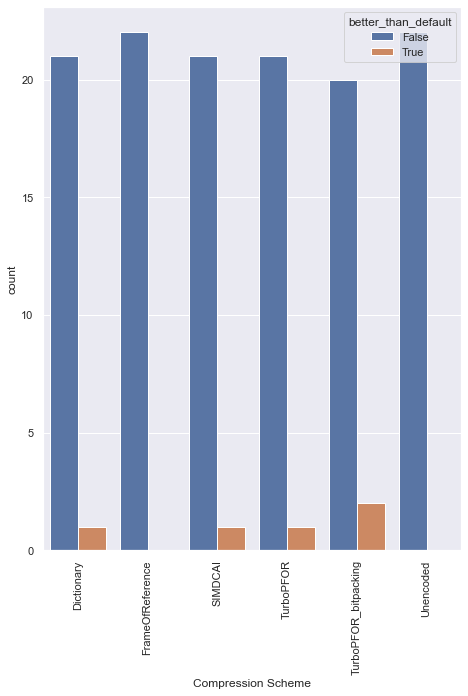

In [25]:
is_better_single: DataFrame = single_with_unencoded_baseline.copy()
is_better_multi: DataFrame = multi_with_unencoded_baseline.copy()
is_better_single[bn.BETTER_THAN_DEFAULT] = [rel_runtime < 1 for rel_runtime in is_better_single[bn.RUNTIME_TO_BASELINE]]
is_better_multi[bn.BETTER_THAN_DEFAULT] = [rel_runtime < 1 for rel_runtime in is_better_multi[bn.RUNTIME_TO_BASELINE]]
order: List[str] = sorted(is_better_single[bn.LIBRARY_NAME].drop_duplicates())
sns.countplot(data=is_better_single, x=bn.LIBRARY_NAME, hue=bn.BETTER_THAN_DEFAULT, order=order)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Dictionary'),
  Text(1, 0, 'FrameOfReference'),
  Text(2, 0, 'SIMDCAI'),
  Text(3, 0, 'TurboPFOR'),
  Text(4, 0, 'TurboPFOR_bitpacking'),
  Text(5, 0, 'Unencoded')])

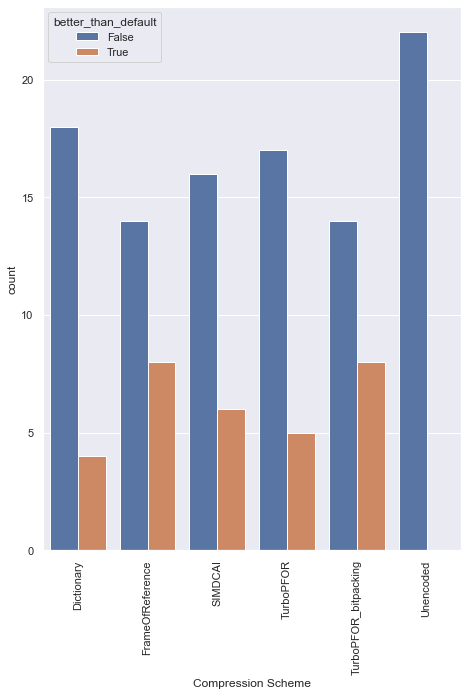

In [26]:
sns.countplot(data=is_better_multi, x=bn.LIBRARY_NAME, hue=bn.BETTER_THAN_DEFAULT, order=order)
plt.xticks(rotation=90)

In [27]:
integer_compressed: DataFrame = bn.load_sizes(sizes_folder / "sizes_Dictionary.txt")
dictionary: DataFrame = bn.load_sizes(sizes_folder / "sizes_Unencoded.txt")
columns_to_merge: List[str] = ["table_name", "chunk_id", "column_id", bn.SIZE_IN_BYTES]
merged: DataFrame = integer_compressed.merge(dictionary[columns_to_merge], on=["table_name", "chunk_id", "column_id"],
                                             suffixes=("","_baseline"))

In [28]:
# Get DB Columns where Int Compression Had the most impact
sizes_per_column = merged.groupby(["table_name", "column_name", bn.DATA_TYPE], as_index=False)[bn.SIZE_IN_BYTES, f"{bn.SIZE_IN_BYTES}_baseline"].sum()
sizes_per_column["compression"] = [x / y
                                     for x, y in zip(sizes_per_column[bn.SIZE_IN_BYTES],
                                                     sizes_per_column[f"{bn.SIZE_IN_BYTES}_baseline"])]
only_int_columns = sizes_per_column[sizes_per_column[bn.DATA_TYPE] == "int"]

<ipython-input-28-1237b227e0ae>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sizes_per_column = merged.groupby(["table_name", "column_name", bn.DATA_TYPE], as_index=False)[bn.SIZE_IN_BYTES, f"{bn.SIZE_IN_BYTES}_baseline"].sum()


In [29]:
dictionary.groupby([bn.DATA_TYPE], as_index=False)[bn.SIZE_IN_BYTES].sum()

,Data Type,Size (in Bytes)
0,float,676386560
1,int,1266756060
2,string,7950670887


In [30]:
only_28_clients_mult = high_level_mult[high_level_mult[bn.CLIENTS] == 28]
bn.get_relative_to_baseline_high_level(high_level_single, baseline="Unencoded")

,benchmark_run_name,Total Runtime (in seconds),avg_throughput,Compression Scheme,with_lto,Clients,multithreaded,float,int,string,Runtime Library / Runtime Baseline,size_to_baseline,Compression Scheme_baseline,Total Runtime (in seconds)_baseline,int_baseline
0,./tpch_Dictionary_sf10_singlethreaded.json,38.747185,1.537464,Dictionary,False,1,False,676386560.0,1.372782e+09,7.950671e+09,1.154365,1.083699,Unencoded,33.56579,1.266756e+09
1,./tpch_FrameOfReference_sf10_singlethreaded.json,35.447879,1.673023,FrameOfReference,False,1,False,676386560.0,9.912806e+08,7.950671e+09,1.056072,0.782535,Unencoded,33.56579,1.266756e+09
2,./tpch_SIMDCAI_sf10_singlethreaded.json,36.831127,1.531125,SIMDCAI,False,1,False,676386560.0,6.464946e+08,7.950671e+09,1.097282,0.510354,Unencoded,33.56579,1.266756e+09
3,./tpch_TurboPFOR_bitpacking_sf10_singlethreade...,35.077938,1.606486,TurboPFOR_bitpacking,False,1,False,676386560.0,6.557167e+08,7.950671e+09,1.045050,0.517635,Unencoded,33.56579,1.266756e+09
4,./tpch_TurboPFOR_sf10_singlethreaded.json,37.203742,1.531067,TurboPFOR,False,1,False,676386560.0,6.514422e+08,7.950671e+09,1.108383,0.514260,Unencoded,33.56579,1.266756e+09
5,./tpch_Unencoded_sf10_singlethreaded.json,33.565790,1.883015,Unencoded,False,1,False,676386560.0,1.266756e+09,7.950671e+09,1.000000,1.000000,Unencoded,33.56579,1.266756e+09


In [31]:
columns_to_merge: List[str] = [bn.LIBRARY_NAME, bn.RUNTIME_TO_BASELINE, bn.SIZE_TO_BASELINE]
high_level_single[columns_to_merge].merge(only_28_clients_mult[columns_to_merge], on=[bn.LIBRARY_NAME, bn.SIZE_TO_BASELINE])

,Compression Scheme,Runtime Library / Runtime Baseline _x,size_to_baseline,Runtime Library / Runtime Baseline _y
0,Dictionary,1.000000,1.000000,1.000000
1,FrameOfReference,0.914850,0.722096,0.928079
2,SIMDCAI,0.950550,0.470938,0.977628
3,TurboPFOR_bitpacking,0.905303,0.477655,0.935553
4,TurboPFOR,0.960166,0.474542,1.007754
5,Unencoded,0.866277,0.922766,0.904288


In [32]:
def load_benchmark_low(benchmark: str) -> DataFrame:
    multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_multithreaded/")
    low_level_mult: DataFrame = bn.get_low_level(multi_threaded_folder)
    low_level_mult["Benchmark"] = [benchmark for i in range(0, len(low_level_mult))]
    return low_level_mult[low_level_mult[bn.CLIENTS] == 28]

def plot_runtime(data, color=None):
    sns.boxplot(data=data, x=bn.LIBRARY_NAME, y=bn.RUNTIME_TO_BASELINE)
    plt.ylim(0.0, 3)
    plt.xticks(rotation=90)
    plt.axhline(y=1, color='r', linewidth=3, linestyle='--')

low_level_results = load_benchmark_low("tpch").append(load_benchmark_low("tpcds")).append(load_benchmark_low("jo"))
low_level_results  = low_level_results[low_level_results[bn.LIBRARY_NAME] != "Dictionary"]

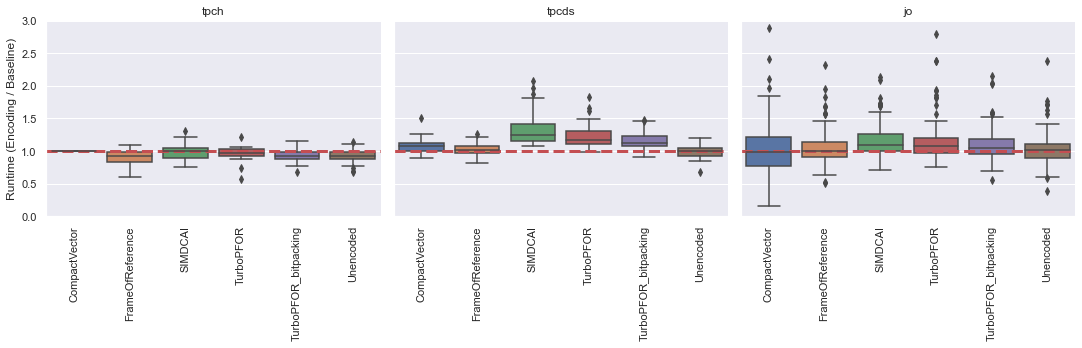

In [33]:
low_level_results = low_level_results.sort_values(by=[bn.LIBRARY_NAME])
grid = sns.FacetGrid(low_level_results, col="Benchmark", col_order=["tpch", "tpcds", "jo"], height=5)
grid.map_dataframe(plot_runtime)
grid.set_titles(col_template="{col_name}")
grid.set_ylabels("Runtime (Encoding / Baseline)")
plt.savefig("visualizations/benchmarks_runtime.svg", bbox_inches="tight")

In [34]:
def load_segment_sizes(benchmark: str, libraries: List[str]) -> DataFrame:
    final_result: DataFrame = DataFrame()
    sizes_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded/")
    dictionary: DataFrame = bn.load_sizes(sizes_folder / "sizes_Dictionary.txt")
    dictionary[bn.LIBRARY_NAME] = ["Dictionary" for i in range(0,len(dictionary))]
    for library in libraries:
        integer_compressed: DataFrame = bn.load_sizes(sizes_folder / f"sizes_{library}.txt")
        integer_compressed[bn.LIBRARY_NAME] = [library for i in range(0,len(integer_compressed))]
        columns_to_merge: List[str] = ["table_name", "chunk_id", "column_id", bn.SIZE_IN_BYTES, bn.LIBRARY_NAME]
        merged: DataFrame = integer_compressed.merge(dictionary[columns_to_merge], on=["table_name", "chunk_id", "column_id"],suffixes=("","_baseline"))
        merged[bn.SIZE_TO_BASELINE] = [x / y
                                     for x, y in zip(merged[bn.SIZE_IN_BYTES],
                                                     merged[f"{bn.SIZE_IN_BYTES}_baseline"])]
        int_columns = merged[merged[bn.DATA_TYPE] == "int"]
        final_result = final_result.append(int_columns)
    final_result["Benchmark"] = [benchmark for i in range(0,len(final_result))]
    return final_result

def plot_sizes(data, color=None):
    sns.boxplot(data=data, x=bn.LIBRARY_NAME, y=bn.SIZE_TO_BASELINE)
    plt.ylim(0.0, 8.0)
    plt.xticks([])
    plt.axhline(y=1, color='r', linewidth=3, linestyle='--')

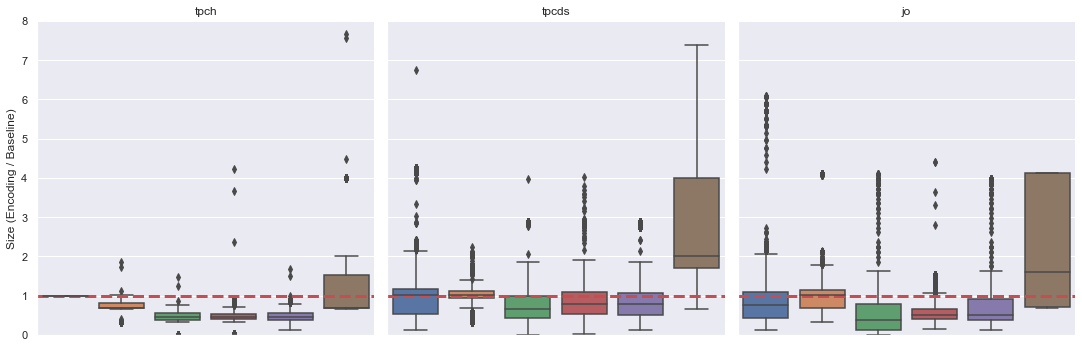

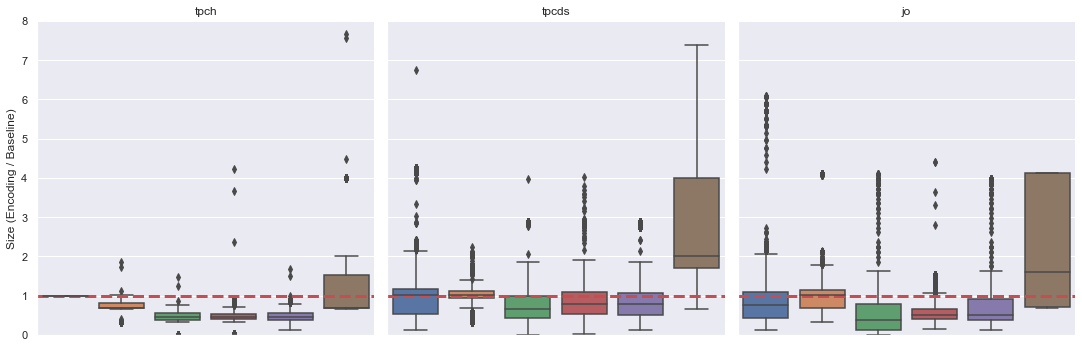

In [35]:
libraries: List[str] = list(high_level_mult[bn.LIBRARY_NAME].drop_duplicates())
libraries.remove("Dictionary")
sizes = load_segment_sizes("tpch", libraries).append(load_segment_sizes("tpcds", libraries)).append(load_segment_sizes("jo", libraries))
sizes = sizes.sort_values(by=[bn.LIBRARY_NAME])
grid = sns.FacetGrid(sizes, col="Benchmark", col_order=["tpch", "tpcds", "jo"], height=5)
grid.map_dataframe(plot_sizes)
grid.set_xlabels("")
grid.set_ylabels("Size (Encoding / Baseline)")
grid.set_titles(col_template="{col_name}")
plt.savefig("visualizations/benchmarks_size.svg", bbox_inches="tight")

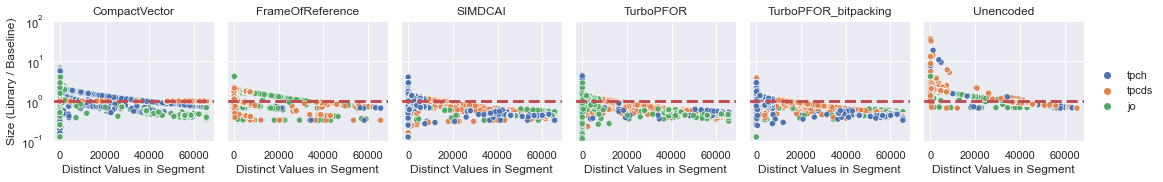

In [46]:
only_one_benchmark = sizes[sizes["Benchmark"] == "tpcds"]
grid = sns.FacetGrid(sizes, col=bn.LIBRARY_NAME, height=2.5)
grid.map_dataframe(sns.scatterplot, x="distinct_value_count", y=bn.SIZE_TO_BASELINE, hue="Benchmark", palette=["C1","C2","C0"]).set(yscale = 'log', ylim=(0.1, 100))
for ax in grid.axes.flatten():
    ax.axhline(y=1, color='r', linewidth=3, linestyle='--')
grid.set_titles(col_template="{col_name}")
grid.set_ylabels("Size (Library / Baseline)")
grid.set_xlabels("Distinct Values in Segment")
grid.add_legend()
plt.savefig("visualizations/benchmarks_size_closer.png", bbox_inches="tight", dpi=300)

In [37]:
def load_benchmark_high_level(benchmark: str, sizes_folder: Path) -> DataFrame:
    single_threaded_folder = Path(f"../data/nemea_{benchmark}_sf10_singlethreaded")
    multi_threaded_folder: Path = Path(f"../data/nemea_{benchmark}_sf10_multithreaded/")
    high_level_mult: DataFrame = bn.get_high_level(multi_threaded_folder, sizes_folder)
    high_level_single: DataFrame = bn.get_high_level(single_threaded_folder, sizes_folder)
    combined = high_level_mult.append(high_level_single)
    combined["Benchmark"] = [benchmark for i in range(0, len(combined)) ]
    return combined

all_results = load_benchmark_high_level("tpch", sizes_folder)\
                .append(load_benchmark_high_level("tpcds", sizes_folder))\
                .append(load_benchmark_high_level("jo", sizes_folder))
without_dict  = all_results[all_results[bn.LIBRARY_NAME] != "Dictionary"]

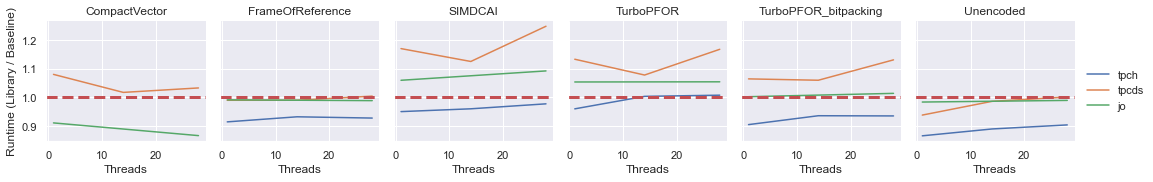

In [45]:
grid = sns.FacetGrid(without_dict, col=bn.LIBRARY_NAME, height=2.5)
grid.map_dataframe(sns.lineplot, x=bn.CLIENTS, y=bn.RUNTIME_TO_BASELINE, hue="Benchmark")
for ax in grid.axes.flatten():
    ax.axhline(y=1, color='r', linewidth=3, linestyle='--')
grid.set_titles(col_template="{col_name}")
grid.set_ylabels("Runtime (Library / Baseline)")
grid.set_xlabels("Threads")
grid.add_legend()
plt.savefig("visualizations/benchmarks_runtime_closer.svg", bbox_inches="tight")